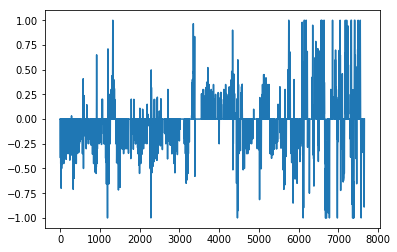

In [39]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

LOG_DIR = '/Users/tempflip/Desktop/rec/'
SERVER_LOG_DIR = '/home/carnd/rec/'
LOG_FILE  = 'driving_log.csv'
log = []

with open(SERVER_LOG_DIR + '/' + LOG_FILE, 'r') as f:
    reader = csv.reader(f)
    log = pd.DataFrame([row for row in reader], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

#print(log[['CENTER', 'STEERING']])
plt.plot(log['STEERING'])


(7653,)
(7653, 160, 320, 3)
255.0 0.0


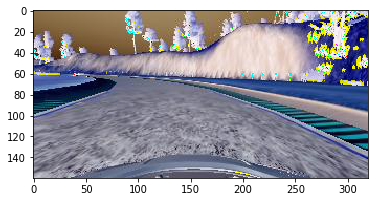

In [40]:
from scipy import misc
im_list = []
for im_file in log['CENTER']:
    im = misc.imread(im_file.replace(LOG_DIR, SERVER_LOG_DIR))
    im_list.append(im)
im_list = np.array(im_list, dtype=np.float32)


steering_targets = np.array(log['STEERING'].values, dtype=np.float32)

print (steering_targets.shape)
print (im_list.shape)
print (np.max(im_list), np.min(im_list))
plt.imshow(im_list[11])

[<tf.Tensor 'add_211:0' shape=(?, 1) dtype=float32>]
(7653, 160, 320, 3) (7653,)


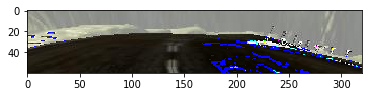

In [42]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

def crop(d):
    return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5

model = Sequential()

model.add(Lambda(normalize, input_shape=(160, 320, 3)))
model.add(Lambda(crop))

model.add(Convolution2D(9,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Convolution2D(18,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)

print(im_list.shape, steering_targets.shape)

plt.imshow(crop(normalize((im_list[7000:7001])))[0])



In [46]:
from sklearn.utils import shuffle
N = 7653
#x_shuffled, y_shuffled = shuffle(im_list, steering_targets)
x_shuffled, y_shuffled = im_list, steering_targets
x_train = x_shuffled[:N]
y_train = y_shuffled[:N]


In [48]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(x_train, y_train, nb_epoch=10, validation_split=0.2, batch_size=500, shuffle=True)


Train on 6122 samples, validate on 1531 samples
Epoch 1/10
6122/6122 [==============================] - 12s - loss: 1.3675 - acc: 0.2426 - val_loss: 0.2761 - val_acc: 0.3246

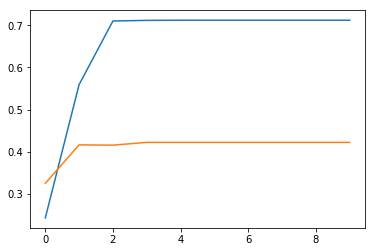

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [50]:
model.save('/home/carnd/ams_model.h5')
print("Saved.")

Saved.
